In [1]:
import mne
import sys
import numpy as np
from matplotlib import pyplot as plt
from asrpy import ASR
from mne.preprocessing import ICA, create_eog_epochs
from mne_bids import (BIDSPath,read_raw_bids)



# Load Data

In [2]:
# path where to save the datasets.
bids_root = "ds003846"
subject_id = '02' # recommend subject 30 for now


bids_path = BIDSPath(subject=subject_id, task="PredictionError", session="EMS",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
raw.info

Extracting parameters from ds003846/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from ds003846/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_events.tsv.
Reading channel info from ds003846/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_channels.tsv.


/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_63207/1149264972.py:11: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 63 EEG, 1 EOG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 250.0 Hz
 meas_date: 1800-12-31 04:11:37 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: sub-02, birthday: 1776-12-30>
>

# Preprocessing

In [3]:
# 50Hz noise: Remove 50 Hz line noise and also 150 Hz noise
raw_filtered = raw.load_data().copy().notch_filter(freqs=[50, 150])
# Filter(Preprocessing): Apply a bandpass filter
raw_filtered = raw_filtered.filter(0.1, 125)
# Resampling: to 250Hz
raw_filtered_resampled = raw_filtered.resample(250)

Reading 0 ... 258029  =      0.000 ...   516.064 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 

In [4]:
# Add montage and set reference channel
raw_filtered_resampled = mne.add_reference_channels(
    raw_filtered_resampled, ref_channels=['FCz'], copy=False
)
montage = mne.channels.make_standard_montage('standard_1020')
raw_filtered_resampled.set_montage(montage)

/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_63207/797934462.py:6: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered_resampled.set_montage(montage)


<RawBrainVision | sub-02_ses-EMS_task-PredictionError_eeg.eeg, 65 x 129017 (516.1 s), ~64.1 MiB, data loaded>

In [5]:
print('FCz' in raw_filtered_resampled.ch_names)


True


In [6]:
# Re-referencing: to average
raw_filtered_resampled_referenced = raw_filtered_resampled.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [7]:
# Patch ASR block covariance to avoid reshape errors when calibration length aligns with the block size
import numpy as np
from asrpy import asr_utils
import asrpy.asr as asr_module

def _block_covariance_safe(data, window=128):
    n_ch, n_times = data.shape
    n_blocks = len(np.arange(0, n_times - 2, window))
    U = np.zeros((n_blocks, n_ch ** 2))
    data_t = data.T
    for k in range(window):
        idx_range = np.minimum(n_times - 1, np.arange(k, n_times + k - 2, window))
        block = (
            data_t[idx_range].reshape(-1, 1, n_ch)
            * data_t[idx_range].reshape(-1, n_ch, 1)
        ).reshape(idx_range.shape[0], n_ch ** 2)
        U += block
    return U

asr_utils.block_covariance = _block_covariance_safe
asr_module.block_covariance = _block_covariance_safe


In [8]:
# Artefact Cleaning: ASR
raw_for_asr = raw_filtered_resampled_referenced.copy()
sfreq = raw_for_asr.info['sfreq']

# only use the first 120 seconds for ASR calibration to avoid being too slow
tmax_calib = min(120, raw_for_asr.times[-1])  # at most 120s, use full length if shorter
raw_calib = raw_for_asr.copy().crop(tmin=0, tmax=tmax_calib)

asr = ASR(sfreq=sfreq, cutoff=5.)
asr.fit(raw_calib)  # use shorter data for calibration
raw_filtered_resampled_referenced_asr = asr.transform(raw_for_asr)  # clean full-length data

/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/asrpy/asr.py:625: RuntimeWarning: divide by zero encountered in matmul
  keep = np.logical_or(D < np.sum((T @ V)**2, axis=0),
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/asrpy/asr.py:625: RuntimeWarning: overflow encountered in matmul
  keep = np.logical_or(D < np.sum((T @ V)**2, axis=0),
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/asrpy/asr.py:625: RuntimeWarning: invalid value encountered in matmul
  keep = np.logical_or(D < np.sum((T @ V)**2, axis=0),
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/asrpy/asr.py:649: RuntimeWarning: divide by zero encountered in matmul
  data[:, subrange] = np.multiply(blend, R @ tmp_data) + \
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/asrpy/asr.py:649: RuntimeWarning: overflow encountered in matmul
  data[:, subrange] = np.multiply(blend, R @ tmp_data) + \
/Users/gujianyang/miniforge3/envs/eeg/li

In [9]:
# Eye Blinks: ICA
ica = ICA(n_components=20, method='fastica', random_state=97)
ica.fit(raw_filtered_resampled_referenced_asr)
eog_indices, eog_scores = ica.find_bads_eog(raw_filtered_resampled_referenced_asr)
print("Detected EOG components:", eog_indices)
ica.exclude = eog_indices
raw_filtered_resampled_referenced_asr_ica = ica.apply(raw_filtered_resampled_referenced_asr.copy())

# Visualizations
# ica.plot_sources(raw_filtered_resampled_referenced_asr)
# raw_filtered_resampled_referenced_asr.plot(n_channels=10, scalings='auto')
# raw_filtered_resampled_referenced_asr_ica.plot(n_channels=10, scalings='auto')

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 0.9s.
Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12

/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: divide by zero encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: overflow encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: invalid

# ERP

In [10]:
raw_preprocessed = raw_filtered_resampled_referenced_asr_ica

evts, evts_dict = mne.events_from_annotations(raw_preprocessed)

event_id_normal = {k: v for k, v in evts_dict.items()
                    if "normal_or_conflict:normal" in k and "box:touched" in k}
evts_normal = evts[np.isin(evts[:, 2], list(event_id_normal.values()))]

event_id_conflict = {k: v for k, v in evts_dict.items()
                      if "normal_or_conflict:conflict" in k and "box:touched" in k}
evts_conflict = evts[np.isin(evts[:, 2], list(event_id_conflict.values()))]


Used Annotations descriptions: [np.str_('block:end;currentBlockNr:1;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:1;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.674886'), np.str_('box:spawned;condition:vibro;trial_nr:10;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.224597'), np.str_('box:spawned;condition:vibro;trial_nr:11;normal_or_conflict:conflict;cube:CubeRight (UnityEngine.GameObject);isiTime:1.552389'), np.str_('box:spawned;condition:vibro;trial_nr:12;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.997462'), np.str_('box:spawned;condition:vibro;trial_nr:13;normal_or_conflict:normal;cube:CubeMiddle (UnityEngine.GameObject);isiTime:1.716086'), np.str_('box:spawned;condition:vibro;trial_nr:14;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.209728'), np.str_('b

In [11]:
# Epoching 
tmin, tmax = -0.1, 1.0  # -100ms to +1s

epochs_normal = mne.Epochs(
    raw_preprocessed,
    evts_normal,
    event_id_normal,
    tmin=tmin,
    tmax=tmax,
    baseline=None, 
    preload=True,
    event_repeated='drop'    
)

epochs_conflict = mne.Epochs(
    raw_preprocessed,
    evts_conflict,
    event_id_conflict,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    preload=True,
    event_repeated='drop'    

)

# EEG Delay Correction 
epochs_normal = epochs_normal.shift_time(-0.063)
epochs_conflict = epochs_conflict.shift_time(-0.063)


Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 276 original time points ...
0 bad epochs dropped
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 50 events and 276 original time points ...
0 bad epochs dropped


In [12]:
# Baseline Correction: Apply bandpass filter 0.5-35Hz instead of explicit baseline correction
epochs_normal = epochs_normal.filter(0.5, 35)
epochs_conflict = epochs_conflict.filter(0.5, 35)


Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (6.604 s)



/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_63207/967164982.py:2: RuntimeWarning: filter_length (1651) is longer than the signal (276), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_normal = epochs_normal.filter(0.5, 35)


Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (6.604 s)



/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_63207/967164982.py:3: RuntimeWarning: filter_length (1651) is longer than the signal (276), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_conflict = epochs_conflict.filter(0.5, 35)


combining channels using "mean"
combining channels using "mean"


/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_63207/1179830358.py:6: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


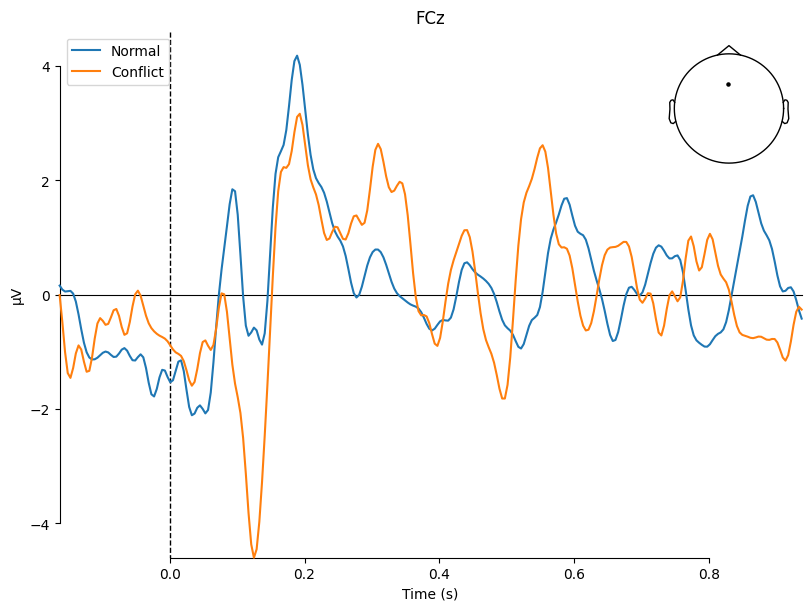

[<Figure size 800x600 with 2 Axes>]

In [13]:
# Electrode: FCz Comparison 
evoked_normal = epochs_normal.copy().pick("FCz").average()
evoked_conflict = epochs_conflict.copy().pick("FCz").average()

# Plotting
mne.viz.plot_compare_evokeds(
    {"Normal": evoked_normal, "Conflict": evoked_conflict},
    picks="FCz",
    combine="mean"
)
